# Cleaning Quickly


In [5]:
# Loading in the dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import IPython.display as display

In [6]:
# Loading in the outputted drift rate csv file and changing the typo hihi

drift_rates = pd.read_csv('drift_rates.csv')

drift_rates['Category'] = drift_rates['Category'].replace({
    'low domonance': 'low dominance'  
})

drift_rates.loc[drift_rates["Category"].str.contains("affiliation", case=False), "Dimension"] = "Affiliation"
drift_rates.loc[drift_rates["Category"].str.contains("dominance", case=False), "Dimension"] = "Dominance"

# Simplify Category to just "low" or "high"
def simplify_category(row):
    if row["Dimension"] in ["Affiliation", "Dominance"]:
        if "low" in row["Category"].lower():
            return "low"
        elif "high" in row["Category"].lower():
            return "high"
    return row["Category"]

drift_rates["Category"] = drift_rates.apply(simplify_category, axis=1)

# Now safe to build Dimension_Category
drift_rates["Dimension_Category"] = drift_rates["Dimension"] + " | " + drift_rates["Category"]

# Drift Rates



/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: F

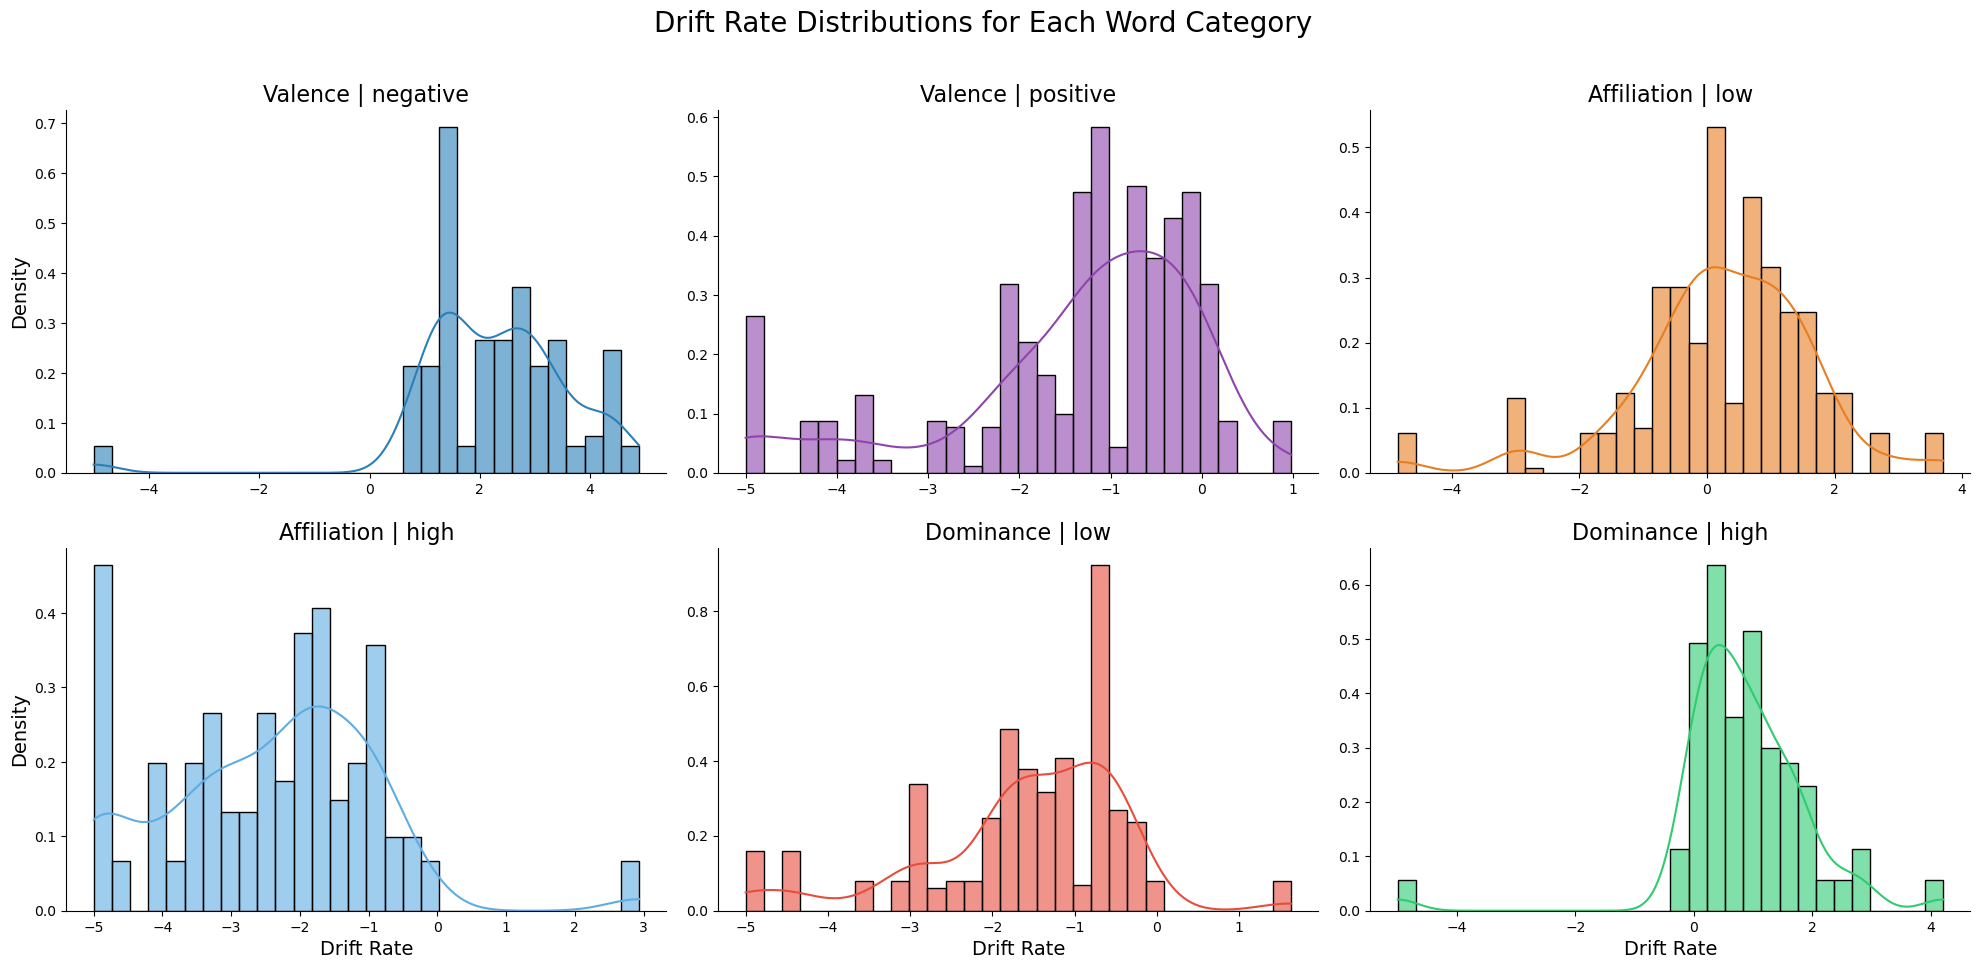

In [3]:
# Having a look at the data distributions

selected_combinations = [
    "Valence | negative",
    "Valence | positive",
    "Circumplex | low affiliation",
    "Circumplex | high affiliation",
    "Circumplex | low dominance",
    "Circumplex | high dominance",
]

drift_rates.loc[drift_rates["Category"].str.contains("affiliation", case=False), "Dimension"] = "Affiliation"
drift_rates.loc[drift_rates["Category"].str.contains("dominance", case=False), "Dimension"] = "Dominance"
filtered_drift_rates = drift_rates
palette = {
    "Valence | negative": "#E74C3C",  
    "Valence | positive": "#2ECC71",       
    "Affiliation | low": "#8E44AD",  
    "Affiliation | high": "#2980B9",
    "Dominance | low": "#5DADE2",   
    "Dominance | high": "#E67E22",   
}

g = sns.FacetGrid(
    filtered_drift_rates,
    col="Dimension_Category",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.5
)

for ax, (dimension_category, subset) in zip(g.axes.flatten(), filtered_drift_rates.groupby("Dimension_Category")):
    color = palette.get(dimension_category, "grey") 
    sns.histplot(
        data=subset,
        x="DriftRate",
        kde=True,
        stat="density",
        common_norm=False,
        bins=30,
        color=color,
        ax=ax,
        alpha=0.6
    )

g.set_axis_labels("Drift Rate", "Density", size = 14)
g.set_titles(col_template="{col_name}", size = 16)

g.tight_layout()
g.figure.set_size_inches(20, 10)
g.figure.subplots_adjust(top=0.88)
g.figure.suptitle("Drift Rate Distributions for Each Word Category ", fontsize=20)

g.figure.show()

# Alpha Values

/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: F

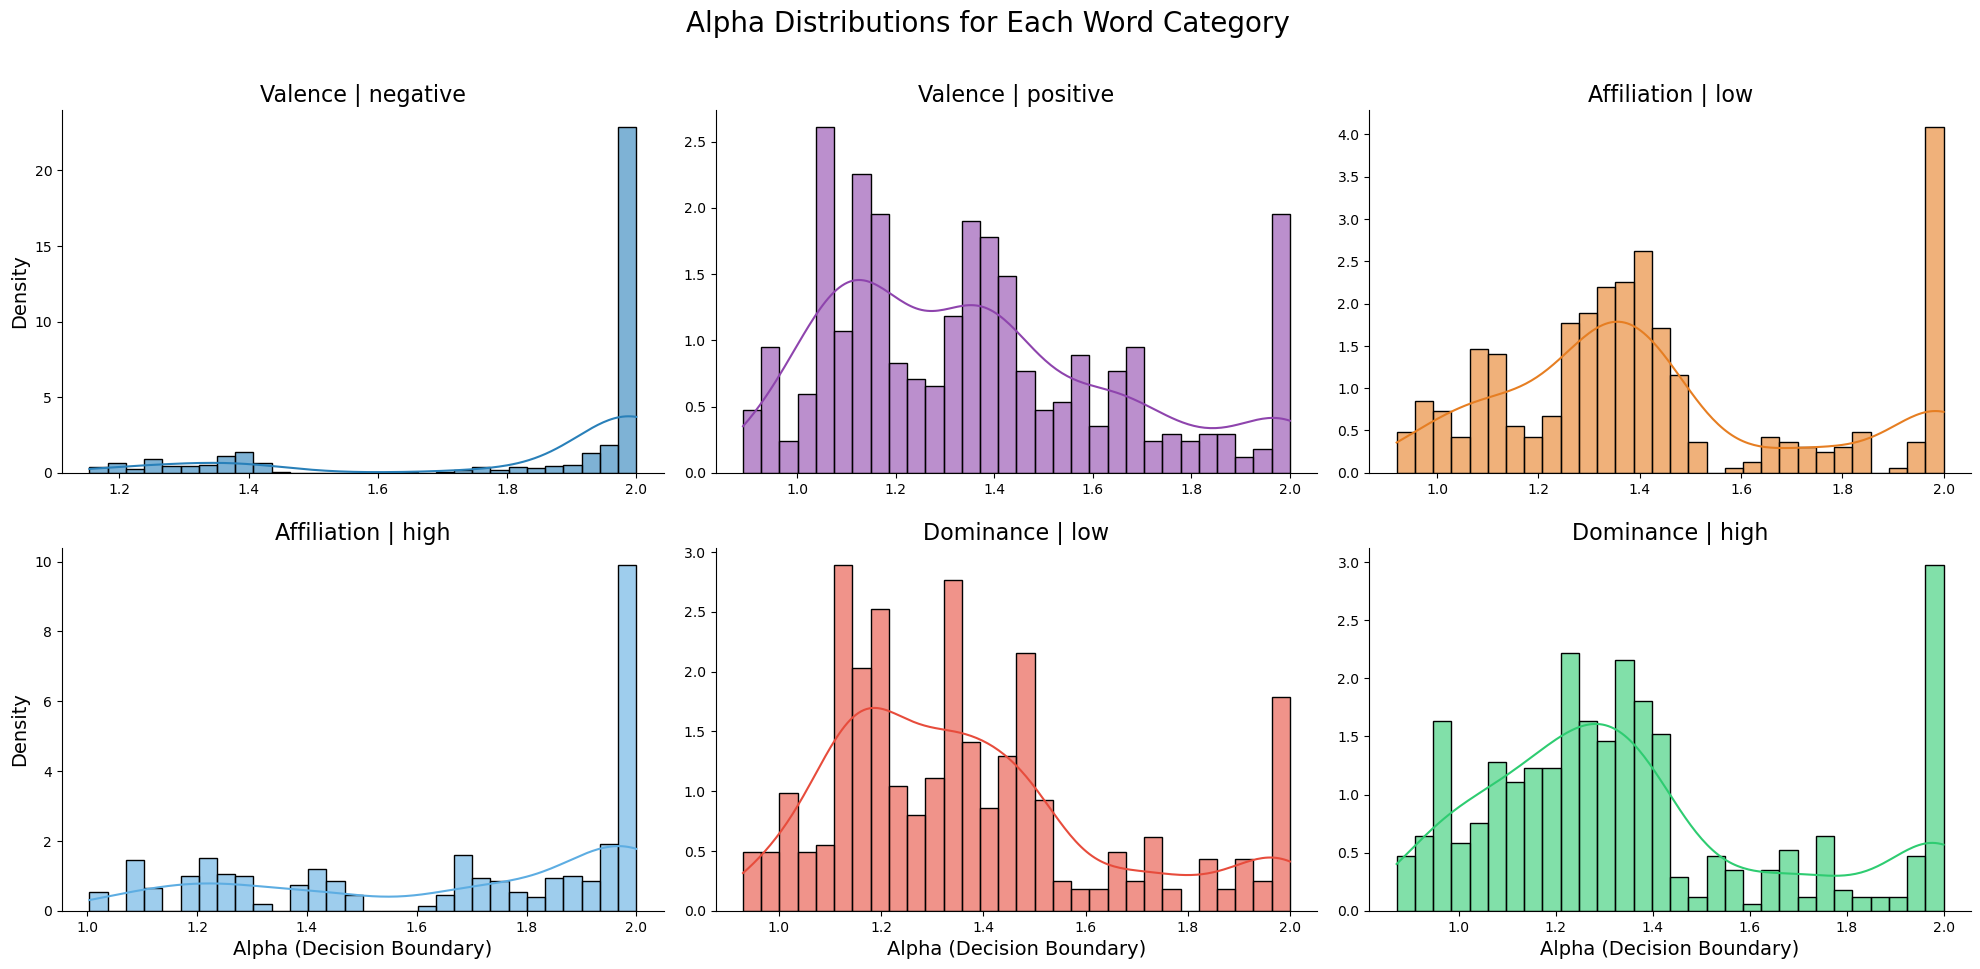

In [4]:
# Create a similar plot for Alpha distributions
g_alpha = sns.FacetGrid(
    filtered_drift_rates,
    col="Dimension_Category",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.5
)

for ax, (dimension_category, subset) in zip(g_alpha.axes.flatten(), filtered_drift_rates.groupby("Dimension_Category")):
    color = palette.get(dimension_category, "grey") 
    sns.histplot(
        data=subset,
        x="Alpha",               
        kde=True,
        stat="density",
        common_norm=False,
        bins=30,
        color=color,
        ax=ax,
        alpha=0.6
    )

g_alpha.set_axis_labels("Alpha (Decision Boundary)", "Density", size=14)
g_alpha.set_titles(col_template="{col_name}", size=16)

g_alpha.tight_layout()
g_alpha.figure.set_size_inches(20, 10)
g_alpha.figure.subplots_adjust(top=0.88)
g_alpha.figure.suptitle("Alpha Distributions for Each Word Category", fontsize=20)

g_alpha.figure.show()

# Bias in starting point

# Correlations

In [8]:
# Seeing the correlations between the drift rates of the clinical scores and the word categories

results = []

# Add helper column for convenience
filtered_drift_rates["Dimension_Category"] = filtered_drift_rates["Dimension"] + " | " + filtered_drift_rates["Category"]


# Correlation helper function
def compute_corr_and_sig(x, y):
    r, p = pearsonr(x, y)
    if p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = 'ns'
    return round(r, 3), format(p, ".3g"), sig

# --------------------
# 1. Specific combos: e.g., Valence | negative
# --------------------
for (dimension_category, measure), group in filtered_drift_rates.groupby(["Dimension_Category", "Measure"]):
    if len(group) >= 5:
        dimension, category = dimension_category.split(" | ")
        
        r_drift, p_drift, sig_drift = compute_corr_and_sig(group["Score"], group["DriftRate"])
        r_alpha, p_alpha, sig_alpha = compute_corr_and_sig(group["Score"], group["Alpha"])

        results.append({
            "Group": f"{dimension} | {category}",
            "Measure": measure,
            "r_drift": f"{r_drift} {sig_drift}",
            "r_alpha": f"{r_alpha} {sig_alpha}"
        })
# --------------------
# 2. Grouped Circumplex dimensions (e.g., Affiliation overall)
# --------------------
for dimension in ["Affiliation", "Dominance"]:
    for measure in filtered_drift_rates["Measure"].unique():
        group = filtered_drift_rates[
            (filtered_drift_rates["Dimension"] == dimension) &
            (filtered_drift_rates["Measure"] == measure)
        ]

        if len(group) >= 5:
            r_drift, p_drift, sig_drift = compute_corr_and_sig(group["Score"], group["DriftRate"])
            r_alpha, p_alpha, sig_alpha = compute_corr_and_sig(group["Score"], group["Alpha"])

            results.append({
                "Group": f"{dimension} (overall)",
                "Measure": measure,
                "r_drift": f"{r_drift} {sig_drift}",
                "r_alpha": f"{r_alpha} {sig_alpha}"
            })

# --------------------
# Format & display as two tables
# --------------------
results_df = pd.DataFrame(results)

# Pivot tables
pivot_drift = results_df.pivot(index="Group", columns="Measure", values="r_drift")
pivot_alpha = results_df.pivot(index="Group", columns="Measure", values="r_alpha")

# Sort rows
row_order = [
    "Valence | negative",
    "Valence | positive",
    "Affiliation | low",
    "Affiliation | high",
    "Dominance | low",
    "Dominance | high",
    "Affiliation (overall)",
    "Dominance (overall)"
]
pivot_drift = pivot_drift.reindex(row_order)
pivot_alpha = pivot_alpha.reindex(row_order)

print("📈 Drift Rate Correlations:")
display.display(pivot_drift)

print("\n📐 Decision Boundary (Alpha) Correlations:")
display.display(pivot_alpha)

📈 Drift Rate Correlations:


Measure,BDI,BFNE,FPES,LSAS,RSES,SPIN,STAI-S,STAI-T
Group,,,,,,,,
Valence | negative,0.463 ***,0.009 ns,-0.014 ns,0.151 ns,-0.355 **,0.101 ns,0.241 ns,0.27 *
Valence | positive,-0.53 ***,-0.26 ns,-0.211 ns,-0.441 ***,0.533 ***,-0.417 **,-0.361 **,-0.348 **
Affiliation | low,0.381 **,0.02 ns,0.095 ns,0.193 ns,-0.353 **,0.14 ns,0.23 ns,0.274 *
Affiliation | high,-0.315 *,0.221 ns,0.204 ns,0.068 ns,0.087 ns,0.102 ns,-0.046 ns,-0.003 ns
Dominance | low,0.37 **,-0.093 ns,-0.124 ns,0.036 ns,-0.197 ns,-0.021 ns,0.15 ns,0.117 ns
Dominance | high,-0.471 ***,-0.443 ***,-0.398 **,-0.554 ***,0.572 ***,-0.532 ***,-0.476 ***,-0.449 ***
Affiliation (overall),0.06 ns,0.038 ns,0.057 ns,0.064 ns,-0.085 ns,0.054 ns,0.057 ns,0.076 ns
Dominance (overall),-0.146 ns,-0.217 *,-0.203 *,-0.245 **,0.223 *,-0.245 **,-0.188 *,-0.182 ns



📐 Decision Boundary (Alpha) Correlations:


Measure,BDI,BFNE,FPES,LSAS,RSES,SPIN,STAI-S,STAI-T
Group,,,,,,,,
Valence | negative,-0.127 ns,0.032 ns,0.273 *,0.252 ns,-0.003 ns,0.302 *,-0.011 ns,0.038 ns
Valence | positive,-0.205 ns,-0.05 ns,0.139 ns,0.114 ns,0.053 ns,0.086 ns,-0.05 ns,-0.006 ns
Affiliation | low,-0.239 ns,-0.106 ns,0.261 *,0.119 ns,0.08 ns,0.166 ns,-0.133 ns,-0.063 ns
Affiliation | high,0.005 ns,0.139 ns,0.172 ns,0.343 **,-0.223 ns,0.34 **,0.139 ns,0.134 ns
Dominance | low,0.096 ns,0.189 ns,0.256 ns,0.376 **,-0.195 ns,0.457 ***,0.175 ns,0.231 ns
Dominance | high,-0.113 ns,0.114 ns,0.198 ns,0.196 ns,-0.055 ns,0.182 ns,0.059 ns,0.073 ns
Affiliation (overall),-0.106 ns,0.027 ns,0.21 *,0.238 *,-0.083 ns,0.259 **,0.015 ns,0.043 ns
Dominance (overall),-0.015 ns,0.147 ns,0.222 *,0.277 **,-0.119 ns,0.307 ***,0.112 ns,0.144 ns
